Imports

In [66]:
import numpy as np
import matplotlib.pyplot as plt  # required for plotting

from functools import partial

from braket.ahs.atom_arrangement import AtomArrangement

from braket.timings.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField

from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.devices import LocalSimulator
from collections import Counter

from scipy.spatial.distance import jensenshannon

In [67]:
import sys
# check using the right virtual environment
sys.prefix

'/Users/yan/Repositories/qhack23_rydberg_graph/venv'

In [68]:
#@title Define the graph

a = 5.3e-6  # nearest-neighbor separation (in meters)

# Define coordiantes of the atoms in the graph A
# as a numpy array of shape (N, 2), where N is the number of nodes
graphA_nodes = np.array([[0., 0.],[0., 1.], [np.sqrt(3)/2, 0.5], [np.sqrt(3)/2 + 1., 0.5], 
                          [np.sqrt(3) + 1., 0.], [np.sqrt(3) + 1., 1.]])
graphB_nodes = np.array([[0., 0.],[0., 1.], [1., 0.], [1, 1], 
                          [2., 0.], [2., 1.]])                          
graphs_nodes = [graphA_nodes, graphB_nodes] 
# register.add(np.array([0.5, 0.5 + 1/np.sqrt(2)]) * a)
# register.add(np.array([0.5 + 1/np.sqrt(2), 0.5]) * a)
# register.add(np.array([0.5 + 1/np.sqrt(2), - 0.5]) * a)
# register.add(np.array([0.5, - 0.5 - 1/np.sqrt(2)]) * a)
# register.add(np.array([-0.5, - 0.5 - 1/np.sqrt(2)]) * a)
# register.add(np.array([-0.5 - 1/np.sqrt(2), - 0.5]) * a)
# register.add(np.array([-0.5 - 1/np.sqrt(2), 0.5]) * a)
# register.add(np.array([-0.5, 0.5 + 1/np.sqrt(2)]) * a)

In [69]:
def get_register(graph_nodes):
    register = AtomArrangement()
    for node in graph_nodes:
        register.add(node * a)
    return register

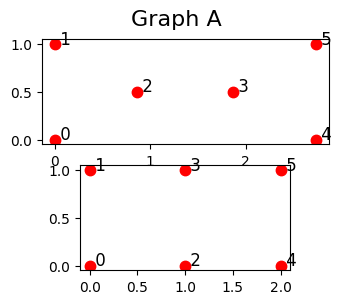

In [92]:
fig, axes = plt.subplots(2, 1, figsize=(7,3))
for ax, graph_nodes in zip(axes, graphs_nodes):
    # register = get_register(graph_nodes)
    xs, ys = (graph_nodes[:, 0], graph_nodes[:, 1])
    ax.plot(xs, ys, 'r.', ms=15)
    for idx, (x, y) in enumerate(zip(xs, ys)):
        ax.text(x, y, f" {idx}", fontsize=12)
    ax.set_aspect('equal')    
    plt.suptitle("Graph A", fontsize=16)
# plt.show()  # this will show the plot below in an ipython or jupyter session

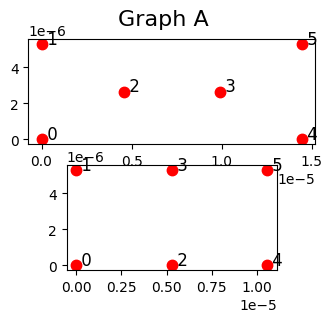

In [70]:
fig, axes = plt.subplots(2, 1, figsize=(7,3))
for ax, graph_nodes in zip(axes, graphs_nodes):
    register = get_register(graph_nodes)
    xs, ys = [register.coordinate_list(dim) for dim in (0, 1)]
    ax.plot(xs, ys, 'r.', ms=15)
    for idx, (x, y) in enumerate(zip(xs, ys)):
        ax.text(x, y, f" {idx}", fontsize=12)
    ax.set_aspect('equal')    
    plt.suptitle("Graph A", fontsize=16)
# plt.show()  # this will show the plot below in an ipython or jupyter session

In [71]:
#@title Define parameters of the simulation
def get_drive(time_max=4e-6):
    """AnalogHamiltonianSimulation requires a DrivingField object as input.
    This function returns a DrivingField object that represents the driving 
    used in https://arxiv.org/pdf/2211.16337.pdf

    Args:
        time_max (float): The maximum time (in seconds) of the driving field. 
        The driving field is defined for 0 <= t <= time_max.
    
    Returns:
        DrivingField: The driving field
    """
    # smooth transition from "down" to "up" state
    # time_max = 4e-6  # seconds
    time_ramp = 1e-8  # seconds
    # omega_max = 1e6  # rad / sec
    omega_max = 6300000.0  # rad / sec
    # delta_start = -5 * omega_max
    # delta_end = 5 * omega_max
    delta_start = 0.7 * omega_max
    phi_start = 0.06 * omega_max
    delta_end = 0.7 * omega_max

    omega = TimeSeries()
    omega.put(0.0, omega_max)
    omega.put(time_max, omega_max)    
    # omega.put(0.0, 0.0)
    # omega.put(time_ramp, omega_max)
    # omega.put(time_max - time_ramp, omega_max)
    # omega.put(time_max, 0.0)
    # omega.put(omega_max, omega_max)

    delta = TimeSeries()
    delta.put(0.0, delta_start)
    # delta.put(time_ramp, delta_start)
    # delta.put(time_max - time_ramp, delta_end)
    delta.put(time_max, delta_start)
    # delta.put(delta_start, delta_end)

    phi = TimeSeries().put(0.0, phi_start).put(time_max, phi_start)

    drive = DrivingField(
        amplitude=omega,
        phase=phi,
        detuning=delta
    )
    return drive 

In [72]:
drive = get_drive()

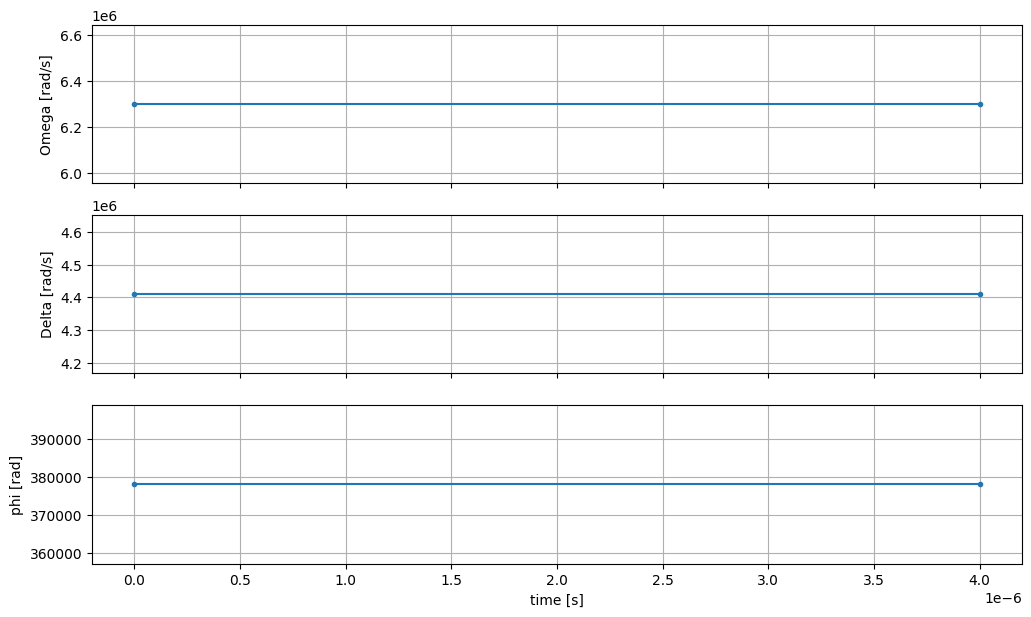

In [73]:
fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True)

ax = axes[0]
time_series = drive.amplitude.time_series
ax.plot(time_series.times(), time_series.values(), '.-');
ax.grid()
ax.set_ylabel('Omega [rad/s]')

ax = axes[1]
time_series = drive.detuning.time_series
ax.plot(time_series.times(), time_series.values(), '.-');
ax.grid()
ax.set_ylabel('Delta [rad/s]')

ax = axes[2]
time_series = drive.phase.time_series
# Note: time series of phase is understood as a piecewise constant function
ax.step(time_series.times(), time_series.values(), '.-', where='post');
ax.set_ylabel('phi [rad]')
ax.grid()
ax.set_xlabel('time [s]')

plt.show()  # this will show the plot below in an ipython or jupyter session


In [103]:

def run_simulation(device, register, drive, shots):
    """Run the simulation on the given device and return the results.
    
    Args:
        device (Device): The device to run the simulation on
        register (AtomArrangement): The register to run the simulation on
        drive (DrivingField): The driving field to use in the simulation
        shots (int): The number of shots to run the simulation for
    
    Returns:
        Counter: The results of the simulation
    """
    ahs_program = AnalogHamiltonianSimulation(
        register=register,
        hamiltonian=drive
    )
    result_simulator = device.run(ahs_program, shots=shots).result()
    return result_simulator

# ahs_program = AnalogHamiltonianSimulation(
#     register=register,
#     hamiltonian=drive
# )

def get_counts_summed_probabilities(result, shots, averaged_nodes=None):
    """Aggregate probabilities of the summed states from AHS shot results
    
    Args:
       result (braket.tasks.analog_hamiltonian_simulation_quantum_task_result.AnalogHamiltonianSimulationQuantumTaskResult)

    Returns:
        np.ndarray: probability of each summed state
    """
    state_counts = get_counts(result) # get state counts from simulator result
    n_nodes = len(list(state_counts.keys())[0]) # number of nodes in graph
    n_prob = np.zeros(n_nodes+1) # initialize array of probabilities for possible number of spins up
    total_counts = {}
    for k, v in state_counts.items(): # sum counts of states with same number of spins up `1`
        new_k = k.count('1')
        total_counts[new_k] = total_counts.get(new_k, 0) + v
    for k, v in total_counts.items(): # convert counts to probabilities
        n_prob[k] = v / shots
    assert np.isclose(np.sum(n_prob), 1.0) # ensure probabilities sum to 1    
    if averaged_nodes is not None:
        n_expectationB = sum(n_prob[averaged_nodes]) # expectation value of up spins in B
        averaged_nodesC = list(set(range(n_nodes)) - set(averaged_nodes)) # nodes not in B
        n_expectationC = sum(n_prob[averaged_nodesC]) 
        return n_expectationB, n_expectationC
    return n_prob

def get_counts(result):
    """Aggregate state counts from AHS shot results

    A count of strings (of length = # of spins) are returned, where
    each character denotes the state of a spin (site):
       e: empty site
       u: up state spin
       d: down state spin

    Args:
       result (braket.tasks.analog_hamiltonian_simulation_quantum_task_result.AnalogHamiltonianSimulationQuantumTaskResult)

    Returns
        dict: number of times each state configuration is measured

    """
    state_counts = Counter()
    states = ['e', '1', '0']
    for shot in result.measurements:
        pre = shot.pre_sequence
        post = shot.post_sequence
        state_idx = np.array(pre) * (1 + np.array(post))
        state = "".join(map(lambda s_idx: states[s_idx], state_idx))
        state_counts.update((state,))
    return dict(state_counts)

def get_expectations_nodes(result, shots, averaged_nodes=None):
    """Compute expectations of up spins in averaged_nodes and up spins in the complement of averaged_nodes
    
    Args:
       result (braket.tasks.analog_hamiltonian_simulation_quantum_task_result.AnalogHamiltonianSimulationQuantumTaskResult)

    Returns:
        np.ndarray: (2,) array for expectation value of up spins in averaged_nodes and 
        up spins in the complement of averaged_nodes
    """
    def _get_counts_node(state_counts, node):
        """Helper function: Aggregate state counts from AHS shot results for a single node"""
        counts_node = [0, 0]
        for k, v in state_counts.items(): # sum spins up `1` and down `0` for node
            new_k = int(k[node])
            counts_node[new_k] = counts_node[new_k] + v
        return np.array(counts_node)

    state_counts = get_counts(result) # get state counts from simulator result
    n_nodes = len(list(state_counts.keys())[0]) # number of nodes in graph
    n_expectation_lists = []
    for node in averaged_nodes:
        counts_node = _get_counts_node(state_counts, node)
        n_expectation_lists.append(counts_node[1] / shots)
    averaged_nodesC = list(set(range(n_nodes)) - set(averaged_nodes)) # nodes not in B      
    n_expectation_listsC = []   
    for node in averaged_nodesC:
        counts_node = _get_counts_node(state_counts, node)
        n_expectation_listsC.append(counts_node[1] / shots)
    return np.mean(n_expectation_lists), np.mean(n_expectation_listsC)
     

In [104]:
def compute_kernel(results_graph, kernel_fn):
    """Compute the kernel matrix for the given results for all the graphs and kernel function.
    
    Args:
        results_graph (list): The list of `result_simulator` for each graph
        kernel_fn (function): The kernel function to use

    Returns:
        np.ndarray: The kernel matrix
    """
    n_graphs = len(results_graph)
    kernel_matrix = np.zeros((n_graphs, n_graphs))
    for i in range(n_graphs):
        for j in range(i+1, n_graphs):
            kernel_matrix[i, j] = kernel_fn(results_graph[i], results_graph[j])
            kernel_matrix[j, i] = kernel_matrix[i, j]
    return kernel_matrix

def compute_outcomes(results_graph, outcome_fn):
    """
    Compute the outcomes for the given results for all the graphs and outcome function.
    """
    n_graphs = len(results_graph)
    outcomes = []
    for i in range(n_graphs):
        outcomes.append(outcome_fn(results_graph[i]))
    return np.stack(outcomes)

def outcome_counts(result1, result2, shots, my_nodesB=None):
    """If no nodes function, specified, compute the kernel function for a probability defined by 
    the counts of the summed states.
    If nodes are specified, also return outcome counts for the specified nodes.
    
    Args:
        result1 (braket.tasks.analog_hamiltonian_simulation_quantum_task_result.AnalogHamiltonianSimulationQuantumTaskResult): The result of the first graph
        result2 (braket.tasks.analog_hamiltonian_simulation_quantum_task_result.AnalogHamiltonianSimulationQuantumTaskResult): The result of the second graph

    Returns:
        float: The kernel function value
    """
    n_prob1 = get_counts_summed_probabilities(result1, shots=shots)
    n_prob2 = get_counts_summed_probabilities(result2, shots=shots)
    js_divergence = jensenshannon(n_prob1, n_prob2) # Jensen-Shannon divergence
    if my_nodesB is not None:
        n_prob1, n_expectationB1, n_expectationC1 = get_counts_summed_probabilities(result1, 
                                                                                  shots, my_nodesB)
        n_prob2, n_expectationB2, n_expectationC2 = get_counts_summed_probabilities(result2,
                                                                                    shots, my_nodesB)
        # js_divergence = jensenshannon(n_prob1, n_prob2) # Jensen-Shannon divergence
        return np.array([n_expectationB1, n_expectationC1, n_expectationB2, n_expectationC2])
    # n_prob_list.append(n_prob)
    return np.exp(-js_divergence)

In [128]:
shots = 6_000
device = LocalSimulator("braket_ahs")
t_range = np.linspace(1e-7, 2.5*1e-6, 100)
my_nodesB = [0, 1, 4, 5]
n_prob_list = []
n_expectationB_list = []
n_expectationC_list = []

results = []
# run simulation for different drive durations
for t_max in t_range:
    results_graphs = []
    for graph in graphs_nodes:
        register = get_register(graph) # get register with different graph
        drive = get_drive(t_max) # get drive with different duration
        result_simulator = run_simulation(device, register, drive, shots) # run simulation
        results_graphs.append(result_simulator)
    results.append(results_graphs)

In [129]:
kernel_counts_fn = partial(outcome_counts, shots=shots)
kernels = []
for t_max, results_graph in zip(t_range, results): # loop over different drive durations
    kernel_t = compute_kernel(results_graph, kernel_counts_fn) # compute kernel matrix
    kernels.append(kernel_t)
kernels = np.stack(kernels)

Text(0, 0.5, 'kernel FS')

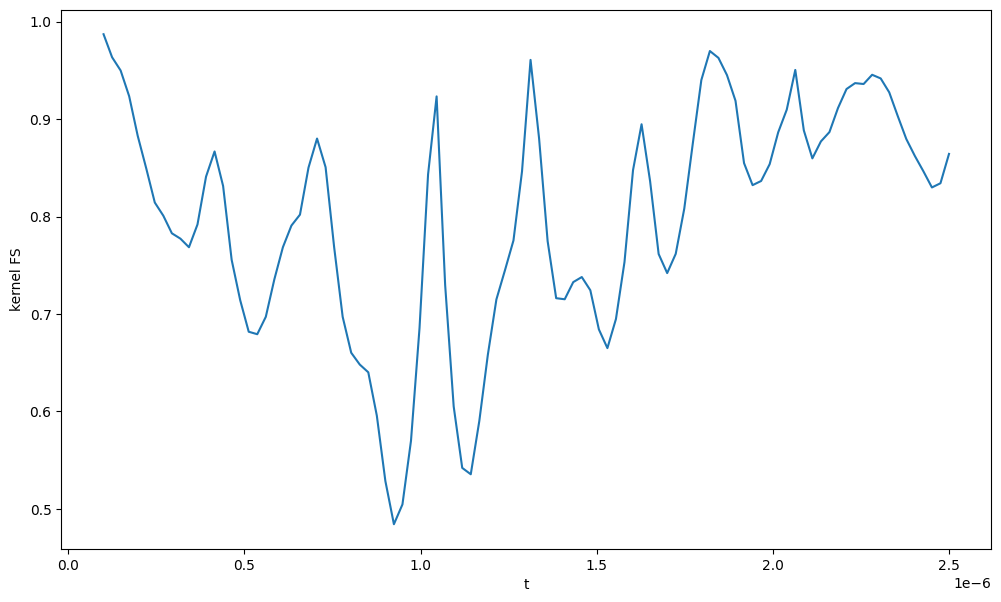

In [130]:
fig, axes = plt.subplots(1, 1, figsize=(12, 7))
axes.plot(t_range, kernels[:, 0, 1], label='kernel')
axes.set_xlabel('t')
axes.set_ylabel('kernel FS')

Text(0, 0.5, 'Jensen-Shannon divergence $JS(P1, P2)$')

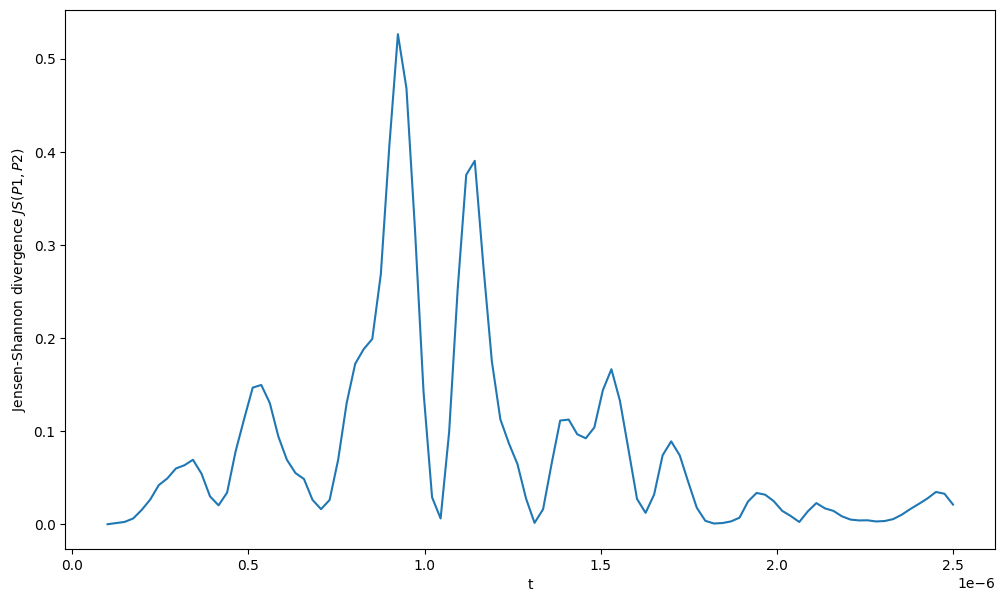

In [131]:
fig, axes = plt.subplots(1, 1, figsize=(12, 7))
axes.plot(t_range, (- np.log(kernels[:, 0, 1]))**2, label='kernel')
axes.set_xlabel('t')
axes.set_ylabel(r'Jensen-Shannon divergence $JS(P1, P2)$')

In [132]:
np.argmin((- np.log(kernels[34:50, 0, 1]))**2)

5

In [133]:
outcome_fn = partial(get_expectations_nodes, shots=shots, averaged_nodes=my_nodesB)
outcomes = []
for t_max, results_graph in zip(t_range, results): # loop over different drive durations
    outcomes_t = compute_outcomes(results_graph, outcome_fn) # compute kernel matrix
    # print(outcomes_t.shape)
    outcomes.append(outcomes_t)
outcomes = np.stack(outcomes)    

Text(0.5, 0, 'Drive duration [s]')

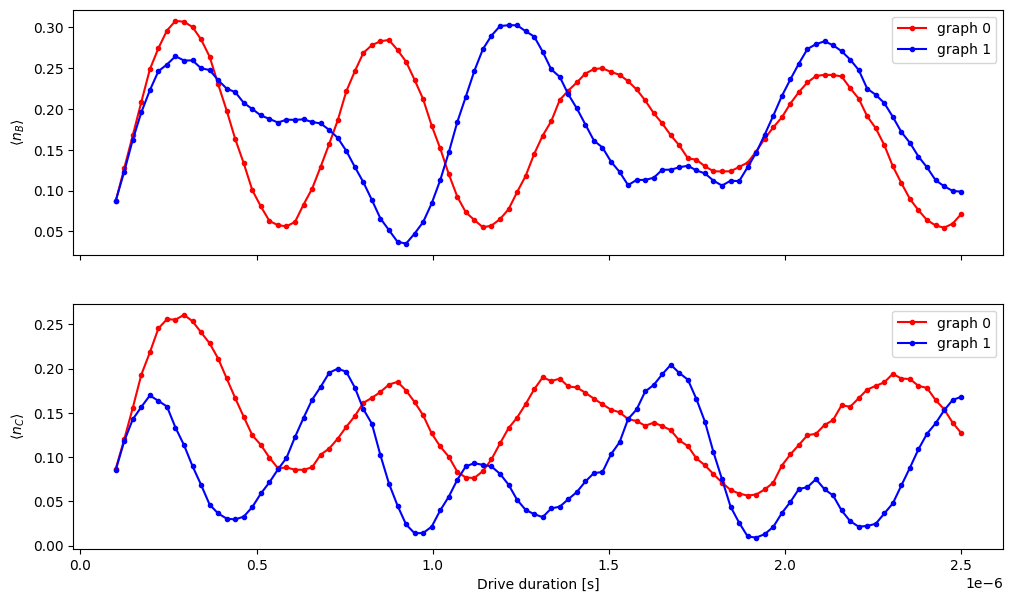

In [134]:
fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
y_labels = [r'$\langle n_B \rangle$', r'$\langle n_C \rangle$']
labels = ['B', 'C']
colors = ['r', 'b']
for i, ylabel in enumerate(y_labels):
    ax = axes[i]
    for j in range(2):
        ax.plot(t_range, outcomes[:, j, i], '.-', label=f"graph {j}", color=colors[j])
    ax.set_ylabel(ylabel)
    ax.legend()

plt.xlabel('Drive duration [s]')
# plt.legend()
# plt.ylabel(r'$\langle n \rangle$')

In [135]:
t_range[39]

1.0454545454545454e-06

[0.54033333 0.3985     0.06116667 0.         0.         0.
 0.        ]
[5.36833333e-01 4.05666667e-01 5.71666667e-02 3.33333333e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
[0.04633333 0.21183333 0.741      0.00083333 0.         0.
 0.        ]
[0.132      0.40416667 0.46316667 0.00066667 0.         0.
 0.        ]
[0.7405     0.11333333 0.14616667 0.         0.         0.
 0.        ]
[0.27866667 0.5365     0.18483333 0.         0.         0.
 0.        ]
[5.00000000e-04 6.17166667e-01 3.81666667e-01 6.66666667e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
[0.89166667 0.02916667 0.07816667 0.001      0.         0.
 0.        ]
[4.82333333e-01 3.53333333e-01 1.64166667e-01 1.66666667e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
[0.4215 0.4595 0.119  0.     0.     0.     0.    ]
[6.47833333e-01 2.13166667e-01 1.38833333e-01 1.66666667e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
[0.10416667 0.4245     0.46966667 0.00166667 0.         0.
 0.        ]
[0.657  0.146

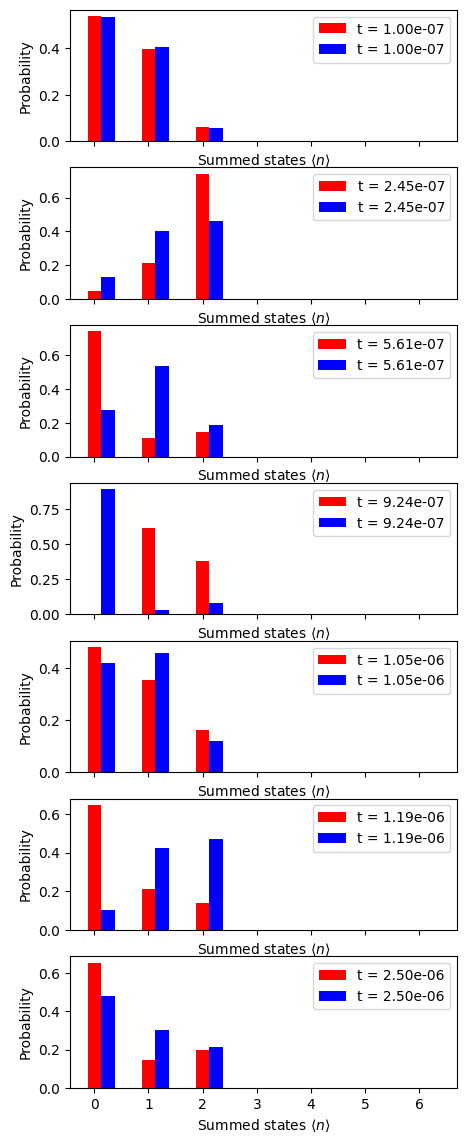

In [136]:
t_list = [0.1e-6, 0.25e-6, 0.57e-6, 0.924e-6, 1.04e-6, 1.2e-6, 2.5e-6]
barWidth = 0.25
br1 = np.arange(len(graphA_nodes)+1)
br2 = [x + barWidth for x in br1]
bars = [br1, br2]
colors = ['r', 'b']
# plot the probability distribution for different drive durations as a function of summed states
fig, axes = plt.subplots(len(t_list), 1, figsize=(5, 2 * len(t_list)), sharex=True)
for t, ax in zip(t_list, axes):
    # idx = np.where(t_range == t)[0][0] # get index of t
    idx = np.argmin(np.abs(t_range - t))
    probabilities = []

    
    for i in range(2):
        p = get_counts_summed_probabilities(results[idx][i], shots=shots)
        probabilities.append(p)
        print(p)

        ax.bar(bars[i], p, label='t = {:.2e}'.format(t_range[idx]), width=barWidth, color=colors[i])
        # ax.set_ylim(0, 1)
        ax.set_ylabel("Probability")
        ax.set_xlabel(r"Summed states $\langle n \rangle$")
        ax.legend()
    # ax.set_title('t = {:.2e}'.format(t))




In [137]:
counts_simulator = get_counts(result_simulator)  # takes about 5 seconds
print(counts_simulator)

{'000000': 2895, '000001': 23, '000010': 29, '000100': 822, '000110': 77, '001000': 896, '001001': 81, '010000': 29, '010001': 38, '010010': 432, '010100': 1, '011000': 78, '011001': 1, '100000': 28, '100001': 472, '100010': 35, '100100': 59, '100110': 3, '110010': 1}
